# Bird Image Classification Project

## Imports and Data Loading

In [2]:
# Imports
from datasets import load_dataset
import evaluate
from glob import glob
from huggingface_hub import notebook_login
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import create_optimizer, DefaultDataCollator, TFViTForImageClassification as ViTForImageClassification, ViTImageProcessor
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define path to data directory
data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')

In [5]:
# Load dataset
dataset = load_dataset(path=data_dir)

Resolving data files:   0%|          | 0/3208 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## EDA

In [6]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['images to predict', 'test', 'train', 'valid']

In [7]:
# Get dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3208
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [8]:
# Get total number of images in dataset
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

In [9]:
# Get number of images to predict
pred_dir = os.path.join(data_dir, 'images to predict')
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

6

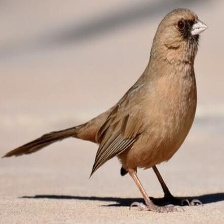

In [10]:
# Load one image from dataset at random
np.random.seed(42)
random_set = np.random.choice(['train', 'validation', 'test'])
random_item = np.random.choice(dataset[random_set])
display(random_item['image'])

In [11]:
# Get size of that image
random_item['image'].size

(224, 224)

## Data Preprocessing

In [12]:
# Login to hugging face hub
notebook_login()

In [13]:
# Load image processor and push it to hugging face hub
checkpoint = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
image_processor.save_pretrained('bird_classifier', push_to_hub=True)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
# Define size
size = (image_processor.size['height'], image_processor.size['width'])

In [15]:
# Define train dataset
train_data_augmentation = keras.Sequential(
  [
    #keras.layers.RandomCrop(size[0], size[1]),
    keras.layers.Rescaling(scale=1./255, offset=-1),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(factor=0.02),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
  ],
  name='train_data_augmentation',
)

In [16]:
# Define validation dataset
val_data_augmentation = keras.Sequential(
    [
        #keras.layers.CenterCrop(size[0], size[1]),
        keras.layers.Rescaling(scale=1./255, offset=-1),
    ],
    name='val_data_augmentation',
)

In [17]:
# Create functions to apply appropriate transformations
def convert_to_tf_tensor(image: Image):
  np_image = np.array(image)
  tf_image = tf.convert_to_tensor(np_image)

  return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [18]:
# Apply transformations
dataset['train'].set_transform(preprocess_train)
dataset['validation'].set_transform(preprocess_val)

In [19]:
# Define data collator
data_collator = DefaultDataCollator(return_tensors="tf")

In [20]:
# Create mapping for categories
labels = dataset['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

## Data Modeling

### Load pre-trained model

In [25]:
# Initialize the model
base_model = ViTForImageClassification.from_pretrained(checkpoint)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [47]:
# Get summary
base_model.summary()

Model: "tf_vi_t_for_image_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769000    
                                                                 
Total params: 86567656 (330.23 MB)
Trainable params: 86567656 (330.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Test some images

#### Compare labels from base model and dataset

In [26]:
# Get some images from the validation set
np.random.seed(42)
random_dataset = np.random.choice(dataset['validation'], 5, replace=False)

preds = []
for item in random_dataset:
  image = item['image']
  actual = id2label[str(item['label'])]
  inputs = image_processor(images=image, return_tensors="tf")
  outputs = base_model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.numpy().argmax(-1).item()
  predicted_label = base_model.config.id2label[predicted_class_idx]

  preds.append({
      'image': image,
      'predicted': predicted_label,
      'actual': actual
  })

val_df = pd.DataFrame(preds)

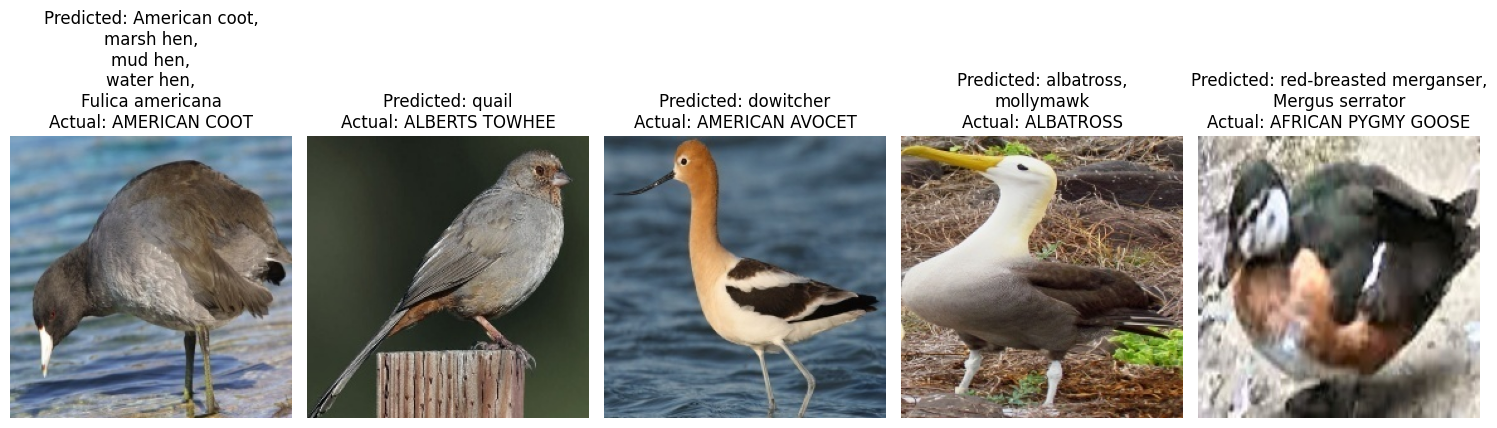

In [27]:
# Display images and labels
images = val_df['image'].to_list()
actual = val_df['actual'].to_list()
predicted = val_df['predicted'].to_list()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

for i in range(5):
    split = predicted[i].split(', ')
    pred_label = 'Predicted: '
    pred_label += ',\n'.join(split) if len(split) > 0 else predicted[i]
    title = f'{pred_label}\nActual: {actual[i]}'
    axes[i].imshow(images[i])
    axes[i].title.set_text(title)
    axes[i].axis("off")

fig.tight_layout()
plt.show()

#### Get labels of images to predict

In [66]:
def display_images(df: pd.DataFrame) -> None:
  nrows = 2
  ncols = 3
  fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))
  images = df['image'].to_list()
  base_pred = df['base_pred'].to_list()
  new_pred = df['new_pred'].to_list() if 'new_pred' in df.columns else None

  for i in range(nrows):
    for j in range(ncols):
      index = (i * ncols) + (j % ncols)
      split = base_pred[index].split(', ')
      base_pred_label = 'Base model: '
      base_pred_label += ',\n'.join(split) if len(split) > 0 else base_pred[index]
      new_pred_label = '\nNew model: ' + new_pred[index] if new_pred else ''
      title = f'{base_pred_label}{new_pred_label}'

      axes[i, j].imshow(images[index])
      axes[i, j].title.set_text(title)
      axes[i, j].axis("off")

  fig.tight_layout()
  plt.show()

In [35]:
# Create dataframe with images to predict
pred_img_paths = sorted(pred_img_paths)
to_predict = []

for img_path in pred_img_paths:
  image = Image.open(img_path)
  inputs = image_processor(images=image, return_tensors="tf")
  outputs = base_model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.numpy().argmax(-1).item()
  pred_label = base_model.config.id2label[predicted_class_idx]

  to_predict.append({
      'image': image,
      'base_pred': pred_label,
  })
to_predict_df = pd.DataFrame(to_predict)

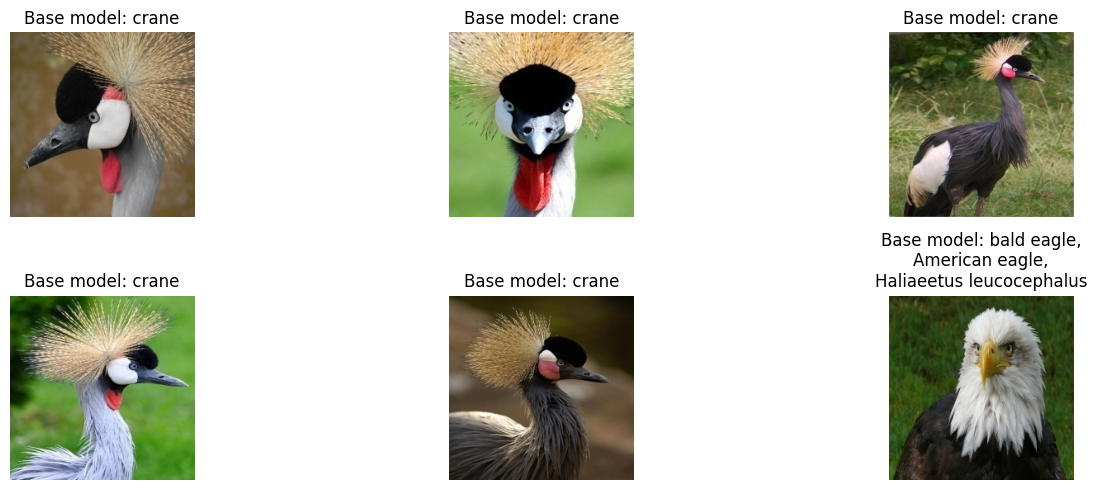

In [36]:
# Display images
display_images(to_predict_df)

### Fine-tune model

In [37]:
# Define optimizer
batch_size = 32
num_epochs = 5
num_train_steps = len(dataset['train']) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [38]:
# Load model with label mappings
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [40]:
# Get summary
model.summary()

Model: "tf_vi_t_for_image_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
Total params: 85814036 (327.35 MB)
Trainable params: 85814036 (327.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Convert datasets to tensorflow dataset
tf_train_dataset = dataset['train'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
tf_val_dataset = dataset['validation'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [42]:
# Configure the model for training
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [43]:
# Load accuracy to evaluate model
accuracy = evaluate.load("accuracy")

In [44]:
# Append accuracy to tensorflow fit method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [45]:
# Fit model
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_dataset, batch_size=batch_size)
model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=metric_callback)

Epoch 1/5
101/101 [==============================] - 2586s 25s/step - loss: 1.3657 - val_loss: 0.2733 - accuracy: 0.9900
Epoch 2/5
101/101 [==============================] - 197s 2s/step - loss: 0.1708 - val_loss: 0.0731 - accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 196s 2s/step - loss: 0.0653 - val_loss: 0.0418 - accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 196s 2s/step - loss: 0.0340 - val_loss: 0.0227 - accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 197s 2s/step - loss: 0.0190 - val_loss: 0.0153 - accuracy: 1.0000


In [48]:
# Push model to hugging face hub
model.push_to_hub('bird_classifier')

tf_model.h5:   0%|          | 0.00/344M [00:00<?, ?B/s]

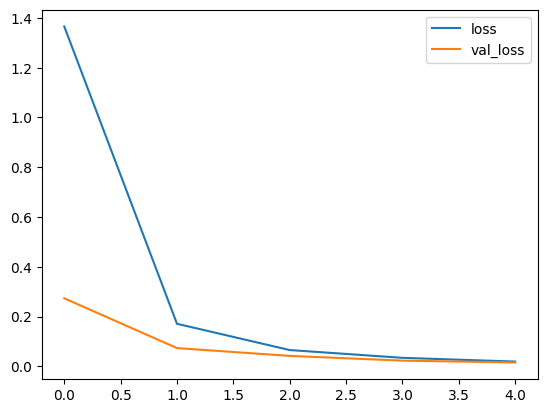

In [49]:
# Plot training vs. validation loss
metrics = pd.DataFrame(model.history.history)
metrics[['loss','val_loss']].plot();

### Evaluate new model with on test set

In [50]:
# Load image processor
checkpoint = 'nadpierre/bird_classifier'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [51]:
# Load new model
new_model = ViTForImageClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/344M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at nadpierre/bird_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [53]:
# Shuffle test set
test_dataset = dataset['test'].shuffle(seed=42)

In [54]:
# Create predicted vs. actual dataframe
preds = []
for item in test_dataset:
  actual = item['label']

  inputs = image_processor(item['image'], return_tensors='tf')
  logits = new_model(**inputs).logits

  preds.append({
      'predicted': int(tf.math.argmax(logits, axis=-1)[0]),
      'actual': actual
  })

preds_df = pd.DataFrame(preds)

In [55]:
# Build classification report
print(classification_report(
    y_true=preds_df['actual'],
    y_pred=preds_df['predicted'],
    labels=range(20),
    target_names=id2label.values()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       1.00      1.00      1.00         5
             ABBOTTS BOOBY       1.00      1.00      1.00         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                 ALBATROSS       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
     ALTAMIRA YELLOWTHROAT       1.00      1.00

## Make predictions

In [61]:
# Add new model predictions to dataframe
def add_pred_label(row):
  image = row['image']
  inputs = image_processor(images=image, return_tensors="tf")
  outputs = new_model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.numpy().argmax(-1).item()
  return new_model.config.id2label[predicted_class_idx]

to_predict_df['new_pred'] = to_predict_df.apply(add_pred_label, axis=1)

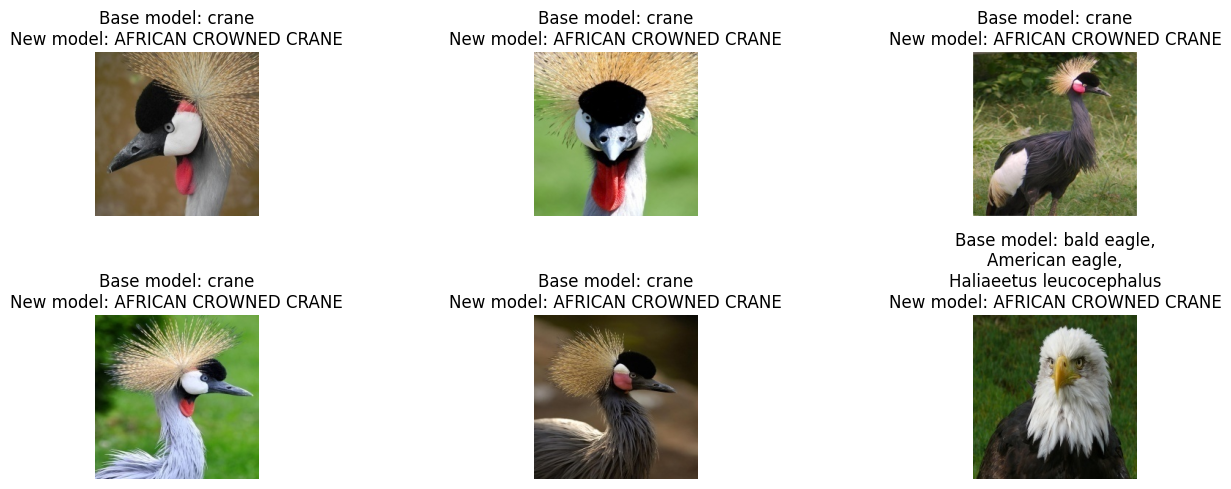

In [67]:
# Display images
display_images(to_predict_df)

The first 5 are correct except the last one, because the dataset didn't have bald eagle pictures.

## End